***

# Machine Learning for time series using signatures and sensitivity analysis

***

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Today, there exists 3 differents python packages to compute signatures :
* esig
* iisignature
* signatory

Let see what package can we choose with a benchmark test.

In [2]:
import esig as ts
import iisignature as isg
import torch
import signatory

import perfplot

Output()

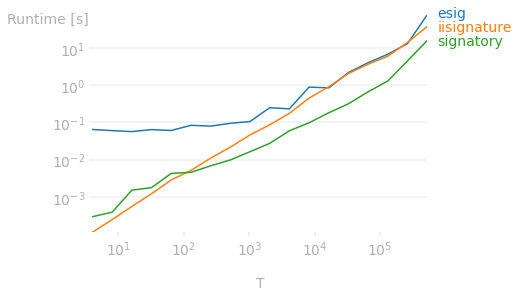

In [4]:
perfplot.show(
    setup=lambda n: np.random.rand(n,10),
    kernels=[
        lambda X: ts.stream2sig(X,4)[1:],
        lambda X: isg.sig(X,4),
        lambda X: signatory.signature(torch.from_numpy(X).unsqueeze(0),4)
    ],
    labels=["esig", "iisignature", "signatory"],
    n_range=[2**k for k in range(2,20)],
    xlabel="T",
)


Si depth 2 nous suffit, alors on peut choisir iisignature. Par contre, si l'on veut des depth plus grande avec beaucoup plus de signatures (ie plus d'information), alors il est plus judicieux de choisir signatory.

Nous allons voir les données que nous avons à disposition et que nous devons traîter.
Nous avons donc $(X_i,Y_i)_{i=1,\dots,n}$, $X_i \in \mathbb{R}^d, \,\, Y_i \in \mathbb{R}$.
les n correspondent à du temps, et le d à la dimension d'un chemin. Nous pouvons interprêter ces données comme d séries temporelles mesurées n fois en fonction du temps. Ce jeux de données est observé sur plusieurs vols. La manière la plus simple de modéliser le tout est donc de les voir comme un tenseur d'ordre 3, de taille $n \times d \times m$.

***

## Importance de l'utilisation des signatures :

Pour cette étude sur l'importance des signatures pour la partie Machine Learning du modèle, nous allons comparer les différentes $R_{squared}$ que l'on obtient entre données brutes et les données avec signatures. 

Nous ferons également cet analyse après un lissage/débruitage des données par convolution.

Considérons $(X_1, \dots, X_p)$ chacun vivant dans $\mathbb{R}^n$, ainsi que $Y \in \mathbb{R}^n$.
Pour simplifier la compréhension, on peut voir chaque $X_i \, , i \in \{ 1,\dots,p \}$ comme une série temporelle dans $\mathbb{R}$ que l'on a mesuré $6 \times 10^5$ fois. Dans ce jeu de données, p = 33.

In [12]:
pd_X_train = pd.read_csv ('C:/Users/emari/Desktop/STAGE IMT 2023/X_train_liftoff.csv', sep=";")
pd_Y_train = pd.read_csv ('C:/Users/emari/Desktop/STAGE IMT 2023/y_train_liftoff.csv', sep=";")
pd_X_test  = pd.read_csv ('C:/Users/emari/Desktop/STAGE IMT 2023/X_test_liftoff.csv' , sep=";")
pd_Y_test  = pd.read_csv ('C:/Users/emari/Desktop/STAGE IMT 2023/y_test_liftoff.csv' , sep=";")

# Truncation
start = 0
end   = 50000
conv_window = 10

# Numpy conversion
X_train = pd_X_train.to_numpy()[start:end,:]
X_train[:,0] = 1
Y_train = pd_Y_train.to_numpy()[start:end,1:].squeeze()

X_test = pd_X_test.to_numpy()[start:end,:]
X_test[:,0] = 1
Y_test = pd_Y_test.to_numpy()[start:end,1:].squeeze()

# Print dimensions
print( "Factors dim:", X_train.shape )
print( "Output  dim:", Y_train.shape )
n, factor_count = X_train.shape

Factors dim: (50000, 33)
Output  dim: (50000,)


Observons l'Output que nous devons approcher avec seulement 33 Inputs :

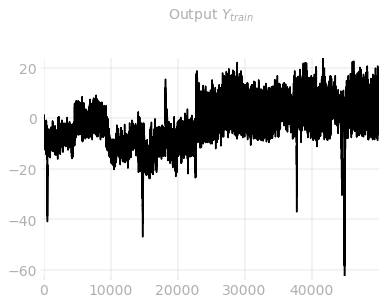

In [27]:
plt.plot(Y_train, 'k-')
plt.grid(True)
plt.title("Output $Y_{train}$")
plt.show()

Maintenant, nous allons créer le nouveau jeu de données auquel on a rajouté les signatures :

In [30]:
def logsig_data(path, memory, depth_sig):
    
    print('shape of time considered during calcul of signatures :', memory)
    window_data=np.zeros( (memory, path.shape[1]) )
    
    shape_sig=0
    sig_list=[]
    for k in range(path.shape[0]):
        if k < memory:
            window_data=np.zeros( (memory, path.shape[1]) )
        else:
            window_data=path[k-memory:k,:]
        
        signatures=signatory.logsignature( torch.from_numpy(window_data).unsqueeze(0), depth=depth_sig )
        sig_list.append(np.array(signatures))
        
        shape_sig=signatures.shape[1] 
    
    sig_array=np.array(sig_list)
    nan_indices = np.where( sig_array != sig_array )
    sig_array[nan_indices] = 0
    
    sig_array=sig_array.squeeze() #for reshape correctly our signatures
    
    print("lenght of one signature :",shape_sig)
    
    new_data=np.append(path, sig_array, axis=1)
    
    return new_data

In [31]:
new_data = logsig_data(X_train, 500, 2)

shape of time considered during calcul of signatures : 500
lenght of one signature : 561


In [ ]:
import statsmodels.api as sm

#### Tests de $R_{squared}$ :

In [ ]:
##OLS entraîné avec les inputs seulement, sans convolution

model_OLS  = sm.OLS(Y_train, X_train)
result_OLS = model_OLS.fit()

#OLS sans convolution, avec rajout des signatures

model_OLS  = sm.OLS(Y_train, new_data)
result_OLS = model_OLS.fit()

#OLS AVEC CONVOLUTION sur les données d'entraînements:

kernel = np.ones((conv_window,))/conv_window

X_conv_list = []
for i in range( X_train.shape[1]):
    convolved = np.convolve( X_train[:,i], kernel, 'valid')
    X_conv_list.append(convolved)
X_train = np.array( X_conv_list ).T
Y_train = np.convolve( Y_train, kernel, 'valid')

#Entraînement du nouveau modèle

model_OLS = sm.OLS(Y_train, X_train)
result_OLS = model_OLS.fit()

## Convolution + Signatures :

model_OLS  = sm.OLS(Y_train, new_data)
result_OLS = model_OLS.fit()

#### Conclusion de l'étude :

$$
\mbox{Sans convolution :} \left\{
    \begin{array}{ll}
        R_{\mbox{squared}}^{brut} &= 0.769 \\
        R_{\mbox{squared}}^{sig} &= 0.817
    \end{array}
\right.
$$

$$
\mbox{Avec convolution :} \left\{
    \begin{array}{ll}
        R_{\mbox{squared}}^{brut} &= 0.928 \\
        R_{\mbox{squared}}^{sig} &= 0.984 \\
        R_{\mbox{squared}}^{alea} &= 0.929
    \end{array}
\right.
$$

***

# Data set 

    Version Windows :

        Nouveau jeu de données :

In [163]:
Input_6101_V08 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0008_LANDING_input.csv", sep=";")
Output_6101_V08 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0008_LANDING_output_5061007F--.csv", sep=";")

Input_6101_V13 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0013_LANDING_input.csv", sep=";")
Output_6101_V13 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0013_LANDING_output_5061007F--.csv", sep=";")

Input_6101_V25 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0025_LANDING_input.csv", sep=";")
Output_6101_V25 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0025_LANDING_output_5061007F--.csv", sep=";")

Input_6101_V27 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0027_LANDING_input.csv", sep=";")
Output_6101_V27 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0027_LANDING_output_5061007F--.csv", sep=";")

Input_6101_V40 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0040_LANDING_input.csv", sep=";")
Output_6101_V40 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0040_LANDING_output_5061007F--.csv", sep=";")

Input_6101_V41 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0041_LANDING_input.csv", sep=";")
Output_6101_V41 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0041_LANDING_output_5061007F--.csv", sep=";")

Input_6101_V53 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0053_LANDING_input.csv", sep=";")
Output_6101_V53 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0053_LANDING_output_5061007F--.csv", sep=";")

Input_6101_V54 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0054_LANDING_input.csv", sep=";")
Output_6101_V54 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0054_LANDING_output_5061007F--.csv", sep=";")

Input_6101_V62 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0062_LANDING_input.csv", sep=";")
Output_6101_V62 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0062_LANDING_output_5061007F--.csv", sep=";")

Input_6101_V67 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0067_LANDING_input.csv", sep=";")
Output_6101_V67 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0067_LANDING_output_5061007F--.csv", sep=";")

Input_6101_V68 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0068_LANDING_input.csv", sep=";")
Output_6101_V68 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0068_LANDING_output_5061007F--.csv", sep=";")

Input_6101_V70 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0070_LANDING_input.csv", sep=";")
Output_6101_V70 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0070_LANDING_output_5061007F--.csv", sep=";")

Input_6101_V89 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0089_LANDING_input.csv", sep=";")
Output_6101_V89 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0089_LANDING_output_5061007F--.csv", sep=";")

Input_6101_V96 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0096_LANDING_input.csv", sep=";")
Output_6101_V96 = pd.read_csv("C:/Users/emari/Desktop/STAGE IMT 2023/A320_6101_V0096_LANDING_output_5061007F--.csv", sep=";")

### convert into numpy array()

X_1, Y_1 = Input_6101_V08.to_numpy(), Output_6101_V08.to_numpy()
X_2, Y_2 = Input_6101_V13.to_numpy(), Output_6101_V13.to_numpy()
X_3, Y_3 = Input_6101_V25.to_numpy(), Output_6101_V25.to_numpy()
X_4, Y_4 = Input_6101_V27.to_numpy(), Output_6101_V27.to_numpy()
X_5, Y_5 = Input_6101_V40.to_numpy(), Output_6101_V40.to_numpy()
X_6, Y_6 = Input_6101_V41.to_numpy(), Output_6101_V41.to_numpy()
X_7, Y_7 = Input_6101_V53.to_numpy(), Output_6101_V53.to_numpy()
X_8, Y_8 = Input_6101_V54.to_numpy(), Output_6101_V54.to_numpy()
X_9, Y_9 = Input_6101_V62.to_numpy(), Output_6101_V62.to_numpy()
X_10, Y_10 = Input_6101_V67.to_numpy(), Output_6101_V67.to_numpy()
X_11, Y_11 = Input_6101_V68.to_numpy(), Output_6101_V68.to_numpy()
X_12, Y_12 = Input_6101_V70.to_numpy(), Output_6101_V70.to_numpy()
X_13, Y_13 = Input_6101_V89.to_numpy(), Output_6101_V89.to_numpy()
X_14, Y_14 = Input_6101_V96.to_numpy(), Output_6101_V96.to_numpy()

    Version Linux

In [59]:
Input_train = pd.read_csv("/home/emilio/Documents/Stage-IMT-2023/First-data-set/X_train_liftoff.csv", sep=";")
Output_train = pd.read_csv("/home/emilio/Documents/Stage-IMT-2023/First-data-set/y_train_liftoff.csv", sep=";")

X_train = Input_train.to_numpy()
Y_train = Output_train.to_numpy()

## Intuition for dataset

In [482]:
plt.plot(X_1[:,2], 'k-', label="2eme serie temporelle du vol 1")
plt.grid(True)
plt.legend()
plt.show()

In [485]:
print("\n taille d'une série temporelle : ", X_1.shape[0], ". \n taille d'un dataset entier : ", X_1.shape, ".")


 taille d'une série temporelle :  1921 . 
 taille d'un dataset entier :  (1921, 41) .


Pour un vol, il y a 40 séries temporelles, avec 1921 observations chacunes. $\newline$ 
La série temporelle suivante est l'output d'un des vols, que nous voulons approcher au mieux.

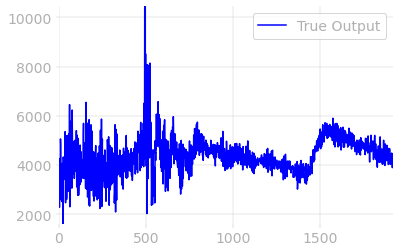

In [183]:
plt.plot(Y_1[:,1], 'b', label="True Output")
plt.legend()
plt.grid(True)
plt.show()

On peut le débruiter un peu pour observer sa tendance.

In [6]:
# Moyenne mobile
def moy_mob(X, order):
    M = np.zeros(X.shape[0] - order + 1)
    for i in range(M.shape[0]):
        M[i] = np.mean(X[i:i+order])
    return M

In [486]:
plt.plot(Y_1[:,1], 'b-', label='true output')
plt.plot(moy_mob(Y_1[:,1], 50), 'orange', label='denoise output')
plt.grid(True)
plt.legend()
plt.show()

***

## Sensitivity analysis

Pour chaque vols, nous allons générer un objet mathématique que l'on appelle signatures, associées à nos processus. Cet objet mathématique est une sorte d'intégrale itérée, infinie, et permet de décrire d'une autre manière un processus temporel, peu importe sa dimension. 

Pour les implémenter, nous allons donc considérer pour chaque vol que l'ensemble de nos données est un chemin temporelle de dimension $D=41$. 

Pour la documentation : Louis Carlier.

Comme les signatures sont des objets de taille infinies, il faut donc choisir un seuil d'arrêt pour les générer numériquement. On s'arrêtera ici au seuil 2, qui génèrera quand même $D + D^2$ signatures.

Ainsi, on génère 861 signatures, ie 861 données en plus des 41 précédentes, toutes de taille 1921 (nombre d'observations initiales).
L'importance de l'analyse de sensibilité est donc judicieux, en vue du grand nombre de données, afin de choisir judicieusement les features les plus intéressantes pour prédire $Y$.

Pour les choisir, une manière intuitive de comprendre ce que nous allons faire est de considérer l'indice de Sobol.
>Soit $X$ et $Y$ 2 variables aléatoires, plus ou moins corrélées entre elles. Pour quantifier leur dépendance, une idée est de calculer la valeur du coefficient suivant :
>>$$
S^{X,Y} = \dfrac{\text{Var}(\mathbb{E}[Y | X])}{\text{Var}(Y)}.
$$
>
>En effet, si $Y$ est fonction de $X$ (totalement dépendante), alors $\mathbb{E}[Y | X] = Y$, et donc $S^{X,Y} = 1$.
A l'inverse, si $Y$ est indépendante de $X$, alors  $\mathbb{E}[Y | X] = \mathbb{E}[Y] = cste$, et donc $\text{Var}(cste) = 0$.
Au final, $S^{X,Y} \in [0,1]$ et facile à comprendre intuitivement.

Malheuresement, les indices de Sobols ont leur limite, par le simple fait qu'ils soient construits seulement par les moments d'ordre 2, ie la variance, donc 2 variables aléatoires qui ont une influence différente sur l'Output $Y$ pourraient avoir la même variance (évènement tout à fait possible), cela limiterait notre étude.

Nous allons maintenant donc voir l'indice de Cramér-von-Mises, qui lui utilise toute la distribution de nos inputs.

$$
S^i_{CvM} = \dfrac{\int_{R^n} Var(\mathbb{E}[Y | X_i])}{xcx}
$$

Pour estimer cet indice, il y a plusieurs façons de procéder : l'estimation Pick-Freeze, U-statistics ou encore par une méthode de rang.***
Pour Pick-Freeze, il faut pouvoir générer des copies indépendantes de nos données, ce qui n'est pas disponible dans notre contexte. J'ai choisis d'utiliser la méthode de rang, qui a été proposée par Chatterjee.




Cet indice est très utile, et n'est pas difficile à estimer.
Mais pour le type de données que nous avons, il nous faut un indice qui gère la dépendance conditionnelle entre $Y$ et $X$.


Proposé par MONA AZADKIA & SOURAV CHATTERJE, un nouveau coefficient est très pratique pour le type de données que nous avons.

>Soit $Y$ une variable aléatoire, $\textbf{X}=(X_1,\dots,X_p)$ et $\textbf{Z}=(Z_1,\dots,Z_q)$ deux vecteurs aléatoires.
Soit $\mu$ la loi de $Y$. on définit $T$ par :
>>$$
T = T(T, \textbf{Z} | \textbf{X} ) = \dfrac{\int \mathbb{E}[\text{Var}(\mathbb{P}(Y \geq t |\textbf{Z}, \textbf{X}) | \textbf{X})] d\mu(t)}{\int \mathbb{E}[\text{Var}(\mathbb{1}_{\{Y \geq t\}} | \textbf{X}] d\mu(t)}$$


Maintenant que nous avons le bon indice, il faut l'estimer. 
La suite de ce notebook propose un estimateur consistant de $T$, également énoncé par Sourav Chatterje.



Let $R_i$ be the rank of $Y_i$, that is the number of j such that $Y_j \leqslant Y_i$.
Let $L_i$ be tje inverse of $R_i$.

>When $\textbf{X}$ is a list of nothing :
>
>>$$T_n = T_n(Y, \textbf{Z}) = \dfrac{\sum_i n \, \text{min}\{ R_i, R_{N(i)} \} - L_i²}{\sum_i L_i(n-L_i)},$$
>>
>where $L_i$ is the number of j such that $Y_j \geq Y_i$.


>When $\textbf{X}$ is not empty :
>
>>$$T_n = T_n(Y,\textbf{Z} | \textbf{X}) = \dfrac{\sum_{i=1}^n \left( \text{min}\{R_i,R_{M(i)}\} - \text{min}\{R_i,R_{N(i)}\}\right)}{\sum_{i=1}^n \left( R_i - \text{min}\{R_i,R_{N(i)}\}\right)},$$
>>
>where $M$ and $N$ are Nearest Neighors permutations.

***

# Implémentation de FOCI

In [13]:
from sklearn.neighbors import NearestNeighbors

### Creation of our data with the signatures : 

L'algorithme suivant permet de générer les signatures associées à un chemin choisi, avec un seuil donné.

In [282]:
def sig_data(path, memory, depth_sig):
    
    print('shape of time considered during calcul of signatures :', memory)
    window_data=np.zeros( (memory, path.shape[1]) )
    
    shape_sig=0
    sig_list=[]
    for k in range(path.shape[0]):
        if k < memory:
            window_data=np.zeros( (memory, path.shape[1]) )
        else:
            window_data=path[k-memory:k,:]
        
        signatures=signatory.logsignature( torch.from_numpy(window_data).unsqueeze(0), depth=depth_sig )
        sig_list.append(np.array(signatures))
        
        shape_sig=signatures.shape[1] 
    
    sig_array=np.array(sig_list)
    nan_indices = np.where( sig_array != sig_array )
    sig_array[nan_indices] = 0
    
    sig_array=sig_array.squeeze() #for reshape correctly our signatures
    
    print("lenght of one signature :",shape_sig)
    
    return sig_array

In [488]:
data_sig1 = sig_data(X_1, 500, 2)
data_sig2 = sig_data(X_2, 500, 2)
data_sig3 = sig_data(X_3, 500, 2)

shape of time considered during calcul of signatures : 500
lenght of one signature : 861
shape of time considered during calcul of signatures : 500
lenght of one signature : 861
shape of time considered during calcul of signatures : 500
lenght of one signature : 861


#### List of zeros features that are common between flight 1 & flight 2 : 

In [491]:
delete1 = np.where(np.var( data_sig1, axis=0 ) == 0)
delete2 = np.where(np.var( data_sig2, axis=0 ) == 0)

deleting = set(delete1[0]).union(set(delete2[0]))
dele = np.array(list(deleting))

### FOCI Algorithm

$\textbf{Remarque préliminaire.}$ Comme nos données sont des séries temporelles, chacune des observations dépendent au minimum de la mesure précédente, ce qui fausserait l'algorithme des plus proches voisins, en prenant souvent celui juste avant ou juste après. Pour remédier à ça, nous allons sous-échantilloner nos données, et choisir les valeurs toutes les 8 mesures (référence au 8 bits).

L'algorithme suivant permet de retourner une liste de nombre, correspondant aux indices d'input sélectionnés par rapport au coefficient de Chatterjee.

Cette méthode est appelée $\textbf{Feature Ordering by Conditionnal Independance} \, \, (FOCI)$.

>Soit $Y$ l'Output considéré, et $\textbf{X} = (X_1,\dots,X_p)$ l'ensemble des features. Supposons que nous avons $n_{sample}$ iid copies de cet ensemble. 
Dans le cas de nos données, p correspondrait à 41+861, et $n_{sample}$ à 1921/8 (nombre d'observations divisées par 8 pour les rendre les plus indépendantes possibles, sans perdre trop d'informations).
Choisissons pour commencer $j_1$, l'indice $j_{star}$ tel que $j_{star} \in \text{argmax}_j T_n(Y, X_j)$.
>
>On note ensuite $j_2$ l'indice $j_{star} \neq j_1$ tel que $j_{star} \in \text{argmax}_j T_n(Y, X_j | X_{j_1})$.
>
>Finallement, après avoir obtenu $\{j_1,\dots,j_k \}$, choisir $j_{k+1} \notin \{j_1,\dots,j_k \}$ tel que
>$j_{k+1} \in \text{argmax}_j T_n(Y, X_j | X_{j_1}, \dots, X_{j_k})$.


Cet algorithme nous renvoie donc la liste des j dans l'ordre décroissant par rapport à l'indice de Chatterjee.
En pratique, on met fin à cet algorithme lorsque l'on tombe sur un $j_{star}$ négatif.

$\textbf{Remarque : }$ Il est également vivement recommandé de standardiser les features avant d'implémenter l'algorithme FOCI. 

In [291]:
def FOCI_function(X, y, memory, dele=None):
    
    delete = np.where(np.var( X, axis=0 ) == 0) ## deleting the zeros inputs 
    if dele is not None:
    
        print("assume delete ",dele)
        print("instead of ",delete)
    
        delete = dele
    else:
            
        print("to be deleted:",delete)
    
    X = np.delete( X, delete, axis = 1)
    
    X_train_stand = (X - np.mean(X, axis=0))/np.var(X, axis = 0)
    Y_train_stand = (y[:,1] - np.mean(y[:,1], axis=0))/np.sqrt(np.var(y[:,1], axis = 0))

    X_iid = np.zeros((int(X.shape[0]/memory),X.shape[1])) 
    Y_iid = np.zeros(int(y.shape[0]/memory))

    for k in range(int(X.shape[0]/memory)): ## we have with this shape 100x40 instead of 2000x40 with iid data 
        X_iid[k,:] = X_train_stand[k*memory,:]
        Y_iid[k] = Y_train_stand[k*memory]
        
    
    Liste_principale = []
    value = []
    
    
    X_iid = np.append(X_iid, np.arange(X_iid.shape[1]).reshape(1,-1), axis=0) ## add a row of arange in our inputs
                                                                              ##  to simplify the code
    Z = X_iid #to keep the notation of the paper
    Y = Y_iid #same as above
    n = Z.shape[0] - 1 #number of rows into our model

    R = np.argsort(Y) #R define below
    L = n - R  #L define below


    T_list=np.zeros(Z.shape[1]) ## T_list is a list of the permutation N
    for i in range(Z.shape[1]):
        NN = NearestNeighbors(n_neighbors=2, algorithm='auto', metric='euclidean').fit(Z[:-1,i].reshape(-1,1))

        # show the two nearest neighbors of each X in R^n, and take the good neighbor
        idx = NN.kneighbors(Z[:-1,i].reshape(-1,1))[1][:,1]

        ## Then, use the previous formula, when X = [], to implement the first iteration of FOCI algorithm :
        T_list[i] = np.sum(n*np.minimum(R,R[idx]) - L**2)/np.sum(L*(n-L))
        
        
    j_star = np.argmax(T_list) #j_star is the index where Tn as the highest value
    print("the argmax of all the estimator coefficient is ", j_star)
    print("This value is ",T_list[j_star])

    Liste_principale.append(j_star)
    value.append(T_list[j_star])
    
    Z2 = X_iid # On stocke la valeur de Z dans Z2
    
    X_=X_iid[:,j_star].reshape(-1,1) # X_ est l'input dont l'indice est j_star 
    idx=j_star

    for l in range(Z2.shape[1]):
        
        X_ = np.concatenate((X_, Z[:,idx].reshape(-1,1)), axis=1) ## X_ is the conditionnal array in the formula
        X_iid = np.delete(X_iid, idx, axis = 1)  #the new Z, without Z[j_star] 
        Z = X_iid  ## construct the new Z

        nn = NearestNeighbors(n_neighbors=2, algorithm='auto', metric='euclidean').fit(X_[:-1,:])
        N = nn.kneighbors(X_)[1][:-1,1]  # la permutation N de l'estimateur      

        T_list=np.zeros(Z.shape[1])
        for i in range(Z.shape[1]):
            NN = NearestNeighbors(n_neighbors=2, algorithm='auto', metric='euclidean').fit(Z[:-1,i].reshape(-1,1))

            M = NN.kneighbors(Z[:-1,i].reshape(-1,1))[1][:,1]  #la permutation M de l'estimateur

            T_list[i] = np.sum(np.minimum(R,R[M]) - np.minimum(R,R[N]))/np.sum(R-np.minimum(R,R[N]))
        if T_list.any() == np.zeros(Z.shape[1]).any():
            break
    
        idx = np.argmax(T_list)
        j_star = int(X_iid[-1, idx])

        Liste_principale = np.append(Liste_principale, j_star)
        value = np.append(value, T_list[idx])
    
    X_iid = np.delete(Z2, -1, axis=0) #On reconstruit X
    
    return Liste_principale, value, delete

In [492]:
drop = 8

##### FOCI FOR FLIGHT 1 :

In [293]:
FOCI_result_1 = FOCI_function(data_sig1, Y_1, drop, dele)

assume delete  [  1   7  12  41  47  52  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 123 124 129 160 161 162 163 166
 172 174 182 183 197 202 232 237 266 269 270 271 277 278 279 287 288 300
 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318
 319 320 321 322 323 324 325 326 327 328 329 330 331 332 336 367 397 426
 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472
 473 474 475 476 477 478 479 480 481 482]
instead of  (array([  1,  12,  41,  52,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 123, 129, 161, 166, 172, 174, 182, 183,
       202, 237, 266, 269, 270, 271, 277, 278, 279, 287, 288, 304, 336,
       367, 397, 426, 455, 456, 457, 458, 459, 460, 461, 46

In [294]:
indice1 = np.where(FOCI_result_1[1] <= 0)
features_keep1 = data_sig1[:,FOCI_result_1[0]]
features_keep1 = features_keep1[:,:539]

##### FOCI FOR FLIGHT 2 :

In [295]:
FOCI_result_2 = FOCI_function(data_sig2, Y_2, drop, dele)

assume delete  [  1   7  12  41  47  52  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 123 124 129 160 161 162 163 166
 172 174 182 183 197 202 232 237 266 269 270 271 277 278 279 287 288 300
 301 302 303 304 305 306 307 308 309 310 311 312 313 314 315 316 317 318
 319 320 321 322 323 324 325 326 327 328 329 330 331 332 336 367 397 426
 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472
 473 474 475 476 477 478 479 480 481 482]
instead of  (array([  1,   7,  12,  41,  47,  52,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100,
       101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 120, 124, 129, 160, 161, 162, 163,
       166, 172, 174, 182, 183, 197, 202, 232, 237, 266, 271, 300, 301,
       302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 31

In [296]:
indice2 = np.where(FOCI_result_2[1] <= 0)
features_keep2 = data_sig2[:,FOCI_result_2[0]]
features_keep2 = features_keep2[:,:361]

#### List of common indices that we keep for Regression :

In [297]:
kept_indice_pos_1 = np.where(FOCI_result_1[1] >= 0)
FOCI_result_1[0][kept_indice_pos_1]

array([  5,  42, 171, 204, 206, 207, 209, 212, 214, 215, 216, 218, 219,
       221, 222, 225, 227, 228,   0, 112, 111, 134, 118, 116, 124, 117,
       113, 125, 119, 129, 115, 132, 122, 109, 110, 121, 120, 138, 126,
       128, 205, 208, 210, 211, 213, 217, 220, 223, 224, 226, 135,  39,
       136, 131, 127, 130, 123, 133,  81,   2, 114, 653,  97,  76, 621,
       326, 239, 413, 663,  78, 107, 192,  77, 298, 666, 100, 485, 278,
       274, 634, 351,  25, 248, 451, 273, 102, 318, 257, 103, 282, 264,
       105, 175, 460, 252, 592, 276,  96, 527, 478, 487,  15, 519, 287,
        37, 247,  83, 300, 530, 523, 159, 658, 277, 387,  28, 654, 657,
        82, 307, 295, 607, 317, 328, 338,  91, 308, 433, 166,  26, 436,
       327, 412, 648,  80,  27, 258, 255, 165, 635, 402, 259, 396, 336,
       346, 288,  23, 386, 589, 503, 472, 229, 303, 379,  53, 254,  22,
        90, 609, 143,  93, 191, 140, 587, 405, 342, 234, 691, 398, 167,
       428, 272, 199, 518, 455, 639, 389, 554, 151, 242,  73, 52

In [298]:
#set(list(features_keep2))
kept_indice_pos_1 = np.where(FOCI_result_1[1] >= 0)
kept_indice_pos_1 = set(FOCI_result_1[0][kept_indice_pos_1])

kept_indice_pos_2 = np.where(FOCI_result_2[1] <= 0)
kept_indice_pos_2=set(FOCI_result_2[0][kept_indice_pos_2])

In [299]:
kept_common_idx = list(kept_indice_pos_1.intersection(kept_indice_pos_2))
print("Indices que l'on va garder : \n", kept_common_idx, "\n nombre d'indices : ", len(kept_common_idx))

Indices que l'on va garder : 
 [640, 1, 259, 263, 8, 521, 264, 524, 15, 17, 657, 658, 20, 274, 662, 276, 402, 542, 288, 674, 163, 38, 166, 41, 297, 171, 298, 45, 686, 428, 48, 309, 569, 314, 316, 701, 702, 191, 580, 68, 711, 713, 330, 587, 77, 78, 333, 80, 208, 82, 209, 336, 467, 472, 218, 219, 220, 95, 223, 97, 352, 227, 100, 228, 614, 615, 229, 233, 106, 234, 491, 628, 251, 252, 254] 
 nombre d'indices :  75


***

Maintenant on utilise la R2 de sklearn pour comparer si on a un meilleur résultat en choisissant les bonnes signatures avec FOCI:

In [320]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [367]:
#X_1_opt = np.append(X_1, data_sig1[:, kept_common_idx], axis=1)
#X_2_opt = np.append(X_2, data_sig2[:, kept_common_idx], axis=1)
#X_1_opt.shape, X_2_opt.shape

X_1_opt = data_sig1[:, kept_common_idx]
X_2_opt = data_sig2[:, kept_common_idx]
X_3_opt = data_sig3[:, kept_common_idx]

In [342]:
reg_OLS = LinearRegression()
reg_OLS.fit(X_1, Y_1[:,1])

r2 = r2_score(Y_2[:500,1], reg_OLS.predict(X_2[:500,:]))
r2

-730.4315294359685

In [343]:
plt.plot(reg_OLS.predict(X_2[:500,:]))

In [368]:
reg_OLS = LinearRegression()
reg_OLS.fit(X_1_opt, Y_1[:,1])

r2 = r2_score(Y_3[500:,1], reg_OLS.predict(X_3_opt[500:,:]))
r2

-1110.3249258980086

In [392]:
# random select some samples between X1 and X2 



array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149])

In [404]:
# just for the fun 
concatenate = np.append(X_1_opt, X_3_opt, axis=1)
liste = np.arange(0,len(X_1_opt[1])*2)

random_list = np.random.choice(liste,X_1_opt.shape[1])

new_data = concatenate[:,random_list]
new_data.shape

(1921, 75)

In [435]:
concatenate = np.append(X_1_opt, X_3_opt, axis=0)
concatenate.shape

(3842, 75)

In [441]:
#reg_OLS = LinearRegression()
reg_OLS.fit(concatenate, np.append(Y_1[:,1],Y_3[:,1]))

r2 = r2_score(Y_3[500:,1], reg_OLS.predict(X_3_opt[500:,:]))
r2

0.5821163575936688

In [443]:

r2 = r2_score(Y_1[500:,1], reg_OLS.predict(X_1_opt[500:,:]))
r2

0.49725901298615116

In [442]:
r2 = r2_score(Y_2[500:,1], reg_OLS.predict(X_2_opt[500:,:]))
r2

-5366792.730606846

In [ ]:
# train with zones where signatures are not null improves a bit on train score but not the test score

In [430]:
concatenate = np.append(X_1_opt[500:], X_3_opt[500:], axis=0)
concatenate.shape

(2842, 75)

In [431]:
np.shape(np.append(Y_1[500:,1],Y_2[500:,1]))

(2842,)

In [432]:
#reg_OLS = LinearRegression()
reg_OLS.fit(concatenate, np.append(Y_1[500:,1],Y_3[500:,1]))

r2 = r2_score(Y_3[500:,1], reg_OLS.predict(X_3_opt[500:,:]))
r2

0.645586647742649

In [433]:

r2 = r2_score(Y_1[500:,1], reg_OLS.predict(X_1_opt[500:,:]))
r2

0.5734239078527228

In [434]:
# but on a new test, bad prediction
r2 = r2_score(Y_2[500:,1], reg_OLS.predict(X_2_opt[500:,:]))
r2

-3401035.120193718

In [421]:
plt.plot(reg_OLS.predict(X_2_opt[500:,:]))

In [ ]:
# KFOLD to avoid overfit

In [422]:
reg_OLS = LinearRegression()
reg_OLS.fit(X_1_opt, Y_1[:,1])

r2 = r2_score(Y_2[500:,1], reg_OLS.predict(X_2_opt[500:,:]))
r2

-927410.3010328271

In [313]:
X_3_opt = np.append(X_3, data_sig3[:, kept_common_idx], axis=1)

In [360]:
kept_randomly=np.random.choice(800, len(kept_common_idx))
random_signatures_1 = data_sig1[500:, kept_randomly]
random_signatures_2= data_sig2[500:, kept_randomly]

In [361]:
reg_OLS = LinearRegression()
reg_OLS.fit(random_signatures_1, Y_1[500:,1])

r2 = r2_score(Y_2[500:,1], reg_OLS.predict(random_signatures_2))
r2

-1.223784595854353e+21

In [276]:
reg_OLS=LinearRegression()
reg_OLS.fit(data_sig, Y_1[:,1])
pred = reg_OLS.predict(data_sig)
reg_OLS.score(data_sig, Y_1[:,1])

0.6034935113543736

In [364]:
plt.plot(Y_1[:,1], label="Y1")
plt.plot(Y_2[:,1], label="Y2")
plt.plot(Y_3[:,1], label="Y3")
plt.legend()
plt.show()

***

# TO DO :
    
    
    
    Solve the problem of Nan values in data_iid (ie. Z) --> DONE
    
    Compute the FOCI algorithm for signatures  --> DONE
    
    Keep just relevant Inputs indices --> DONE
    
    Run an Ordiary Least Squares and look at the R_squared measure to see if we have good results --> DONE
    
    Try to understand how to do the same with more than one flight --> DONE

In [446]:
from sklearn.neighbors import KDTree

In [469]:
def new_FOCI(X, y, memory, dele=None):

    delete = np.where(np.var( X, axis=0 ) == 0) ## deleting the zeros inputs 
    if dele is not None:
    
        print("assume delete ",dele)
        print("instead of ",delete)
    
        delete = dele
    else:
            
        print("to be deleted:",delete)
    
    X = np.delete( X, delete, axis = 1)
   
    
    X_train_stand = (X - np.mean(X, axis=0))/np.var(X, axis = 0) 
    Y_train_stand = (y[:,1] - np.mean(y[:,1], axis=0))/np.var(y[:,1], axis = 0) 
    
    X_iid = np.zeros((int(X_train_stand.shape[0]/memory),X_train_stand.shape[1])) 
    Y_iid = np.zeros(int(y.shape[0]/memory))
    
    for k in range( int(X.shape[0]/memory)):     ## we have with this shape 100x40 instead of 2000x40 with iid data 
        X_iid[k,:] = X_train_stand[k*memory,:]
        Y_iid[k] = Y_train_stand[k*memory]
    
 
    
    Liste_principale = []   ### List of the inputs index in the decreasing order, raising the dependency between                 
    value = []
    
    X_iid = np.append(X_iid, np.arange(X_iid.shape[1]).reshape(1,-1), axis=0) ## add a row of arange in our inputs for simplifying
    print(X_iid.shape)    ## the code
    
    Z = X_iid #to keep the notation of the paper
    Y = Y_iid #same as above
    n = Z.shape[0] - 1 #number of rows into our model

    R = np.argsort(Y) #R define below
    L = n - R  #L define below


    
    T_list=np.zeros(Z.shape[1]) ## T_list is a list of the permutation N
    
    tree=KDTree(Z[:-1,:].transpose(), metric='euclidean')
    for i in range(Z.shape[1]):
        
        # show the two nearest neighbors of each X in R^n, and take the good neighbor
        
        idx = tree.query(Z[:-1,i].transpose().reshape(1,-1), k=2)[1][:,1]
        
        ## Then, use the previous formula, when X = [], to implement the first iteration of FOCI algorithm :
        T_list[i] = np.sum(n*np.minimum(R,R[idx]) - L**2)/np.sum(L*(n-L))  
        
    j_star = np.argmax(T_list) #j_star is the index where Tn as the highest value

    Liste_principale.append(j_star)
    value.append(T_list[j_star])

    Z2 = Z # On stocke la valeur de Z dans Z2 
    tree=KDTree(Z[:-1,:].transpose(), metric='euclidean')
    X_=X_iid[:,j_star].reshape(-1,1) # X_ est l'input dont l'indice est j_star 
    idx=j_star
    
    for l in range(Z2.shape[1]):

        X_ = np.concatenate((X_, Z[:,idx].reshape(-1,1)), axis=1) ## X_ is the conditionnal array in the formula
        X_iid = np.delete(X_iid, idx, axis = 1)  #the new Z, without Z[j_star] 
        Z = X_iid  ## construct the new Z

        nn = NearestNeighbors(n_neighbors=2, algorithm='kd_tree', metric='euclidean').fit(X_[:-1,:])
        N = nn.kneighbors(X_)[1][:-1,1]  # la permutation N de l'estimateur      

        T_list=np.zeros(Z.shape[1])
        for i in range(Z.shape[1]):

            # show the two nearest neighbors of each X in R^n
            M = tree.query(Z[:-1,i].transpose().reshape(1,-1), k=2)[1][:,1]  #la permutation M de l'estimateur

            ## Then, use the previous formula, when X != [], to implement the first iteration of FOCI algorithm :

            T_list[i] = np.sum(np.minimum(R,R[M]) - np.minimum(R,R[N]))/np.sum(R-np.minimum(R,R[N]))
        if T_list.any() == np.zeros(Z.shape[1]).any():
            break
    
        idx = np.argmax(T_list)
        
        j_star = int(X_iid[-1, idx])

        Liste_principale = np.append(Liste_principale, j_star)
        value = np.append(value, T_list[j_star])
    
    X_iid = np.delete(Z2, -1, axis=0) #On reconstruit X
    
    return Liste_principale, value